In [1]:
#Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Import libraries
import os
import re
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from scipy.io import loadmat
from PIL import Image
from tqdm import tqdm
from skimage import io
from skimage import color
from skimage import segmentation

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [31]:
#Set parameters and paths for images and masks
IMAGE_SIZE = 512
BATCH_SIZE = 8
NUM_CLASSES = 25
DATA_DIR = '/content/drive/MyDrive/fdl21-fdl-dsba'

yLabel_list = sorted(glob.glob('/content/drive/MyDrive/fdl21-fdl-dsba/train_masks/train_masks/'+'*.png'))
XImg_list = sorted(glob.glob('/content/drive/MyDrive/fdl21-fdl-dsba/train_images/train_images/'+'*.jpg'))
df = pd.DataFrame(list(zip(XImg_list, yLabel_list)), columns=['image','y'])
train_df, valid_df = train_test_split(df, test_size = 0.1, random_state = 38)
train_images = list(train_df.image)
train_masks = list(train_df.y)
val_images = list(valid_df.image)
val_masks = list(valid_df.y)

In [ ]:
#Define imageg augmentation
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip
def augment_data(images, masks, save_path, split, augment=True):

    for x, y in tqdm(zip(images, masks), total=len(images)):
        name = x.split("/")[-1].split(".")
        """ Extracting the name and extension of the image and the mask. """
        image_name = name[0]
        image_extn = name[1]

        name = y.split("/")[-1].split(".")
        mask_name = name[0]
        mask_extn = name[1]

        """ Reading image and mask. """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)

        """ Augmentation """
        if augment == True:
            aug = RandomRotate90(p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented['image']
            y1 = augmented['mask']

            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented['image']
            y2 = augmented['mask']

            aug = VerticalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']

            save_images = [x1, x2, x3]
            save_masks =  [y1, y2, y3]

        else:
            save_images = [x]
            save_masks = [y]

        """ Saving the image and mask. """
        idx = 0
        for i, m in zip(save_images, save_masks):
            tmp_img_name = f"{image_name}_{idx}.{image_extn}"
            tmp_mask_name = f"{mask_name}_{idx}.{mask_extn}"

            if split == 'train':
              image_path = os.path.join(save_path, 'train_images', tmp_img_name)
              mask_path = os.path.join(save_path, 'train_masks', tmp_mask_name)
            elif split == 'valid':
              image_path = os.path.join(save_path, 'valid_images', tmp_img_name)
              mask_path = os.path.join(save_path, 'valid_masks', tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx += 1

In [ ]:
#Save augmented data
save_path ='/content/img_augmentation'
augment_data(train_images, train_masks, save_path, split = 'train', augment=True)
augment_data(val_images, val_masks, save_path, split = 'valid', augment=True)

100%|██████████| 40/40 [00:58<00:00,  1.47s/it]


In [ ]:
#Include augmented data to training data
yLabel_aug_list = sorted(glob.glob('/content/img_augmentation/train_masks/'+'*.png'))
XImg_aug_list = sorted(glob.glob('/content/img_augmentation/train_images/'+'*.jpg'))
train_aug_df = pd.DataFrame(list(zip(XImg_aug_list, yLabel_aug_list)), columns=['image','y'])
train_aug_df = train_aug_df.sample(frac=.3, random_state=1)
train_combined_df = train_df.append(train_aug_df)
train_images = list(train_combined_df.image)
train_masks = list(train_combined_df.y)

yLabel_aug_list = sorted(glob.glob('/content/img_augmentation/valid_masks/'+'*.png'))
XImg_aug_list = sorted(glob.glob('/content/img_augmentation/valid_images/'+'*.jpg'))
valid_aug_df = pd.DataFrame(list(zip(XImg_aug_list, yLabel_aug_list)), columns=['image','y'])
valid_aug_df = valid_aug_df.sample(frac=.3, random_state=1)
valid_combined_df = valid_df.append(valid_aug_df)
val_images = list(valid_combined_df.image)
val_masks = list(valid_combined_df.y)

In [33]:
#For loading and generating data from the images and masks
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 127.5 - 1
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <BatchDataset shapes: ((8, 512, 512, 3), (8, 512, 512, 1)), types: (tf.float32, tf.float32)>
Val Dataset: <BatchDataset shapes: ((8, 512, 512, 3), (8, 512, 512, 1)), types: (tf.float32, tf.float32)>


In [32]:
#Dilated Spatial Pyramid Pooling 
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [34]:
#Implementation of DeepLabV3+
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    #resnet50 = keras.applications.InceptionResNetV2(
    #    weights='imagenet', include_top=False, input_tensor=model_input
    #)
    #x = resnet50.get_layer("block8_9_ac").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4  // x.shape[2]),       
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    #input_b = resnet50.get_layer("block17_1_ac").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [35]:
#Train model and plot model metrics.
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"]
)
history = model.fit(train_dataset, validation_data=val_dataset, epochs=30)

fig, axs = plt.subplots(2, 2, sharex='col', sharey='row')
axs[0, 0].plot(history.history["loss"])
axs[0, 0].set_title('Training Loss')
axs[0, 1].plot(history.history["val_loss"], 'tab:blue')
axs[0, 1].set_title('Validation Loss')
axs[1, 0].plot(history.history["accuracy"], 'tab:red')
axs[1, 0].set_title('Training Accuracy')
axs[1, 1].plot(history.history["val_accuracy"], 'tab:red')
axs[1, 1].set_title('Validation Accuracy')
plt.setp(axs[0, 0], ylim=(0,5))
# set labels
plt.setp(axs[-1, :], xlabel='Epochs')
plt.setp(axs[0, 0], ylabel='Loss')
plt.setp(axs[1, 0], ylabel='Accuracy')


In [17]:
#Apply the trained model to test images
test_path = sorted(glob.glob('/content/drive/MyDrive/fdl21-fdl-dsba/test_images/test_images/'+'*.jpg'))
for image in test_path:
  image_tensor = read_image(image)
  predictions = model.predict(np.expand_dims((image_tensor), axis=0))
  predictions = np.squeeze(predictions)
  predictions = np.argmax(predictions, axis=2)
  predictions = np.float32(predictions)
  img = Image.fromarray(predictions).convert("L")
  image_name = re.search('\/(\d+\.?\d*)\.', str(image)).group(1)
  filename = os.path.join('/content/test/', image_name+'.png')
  img.save(filename)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.


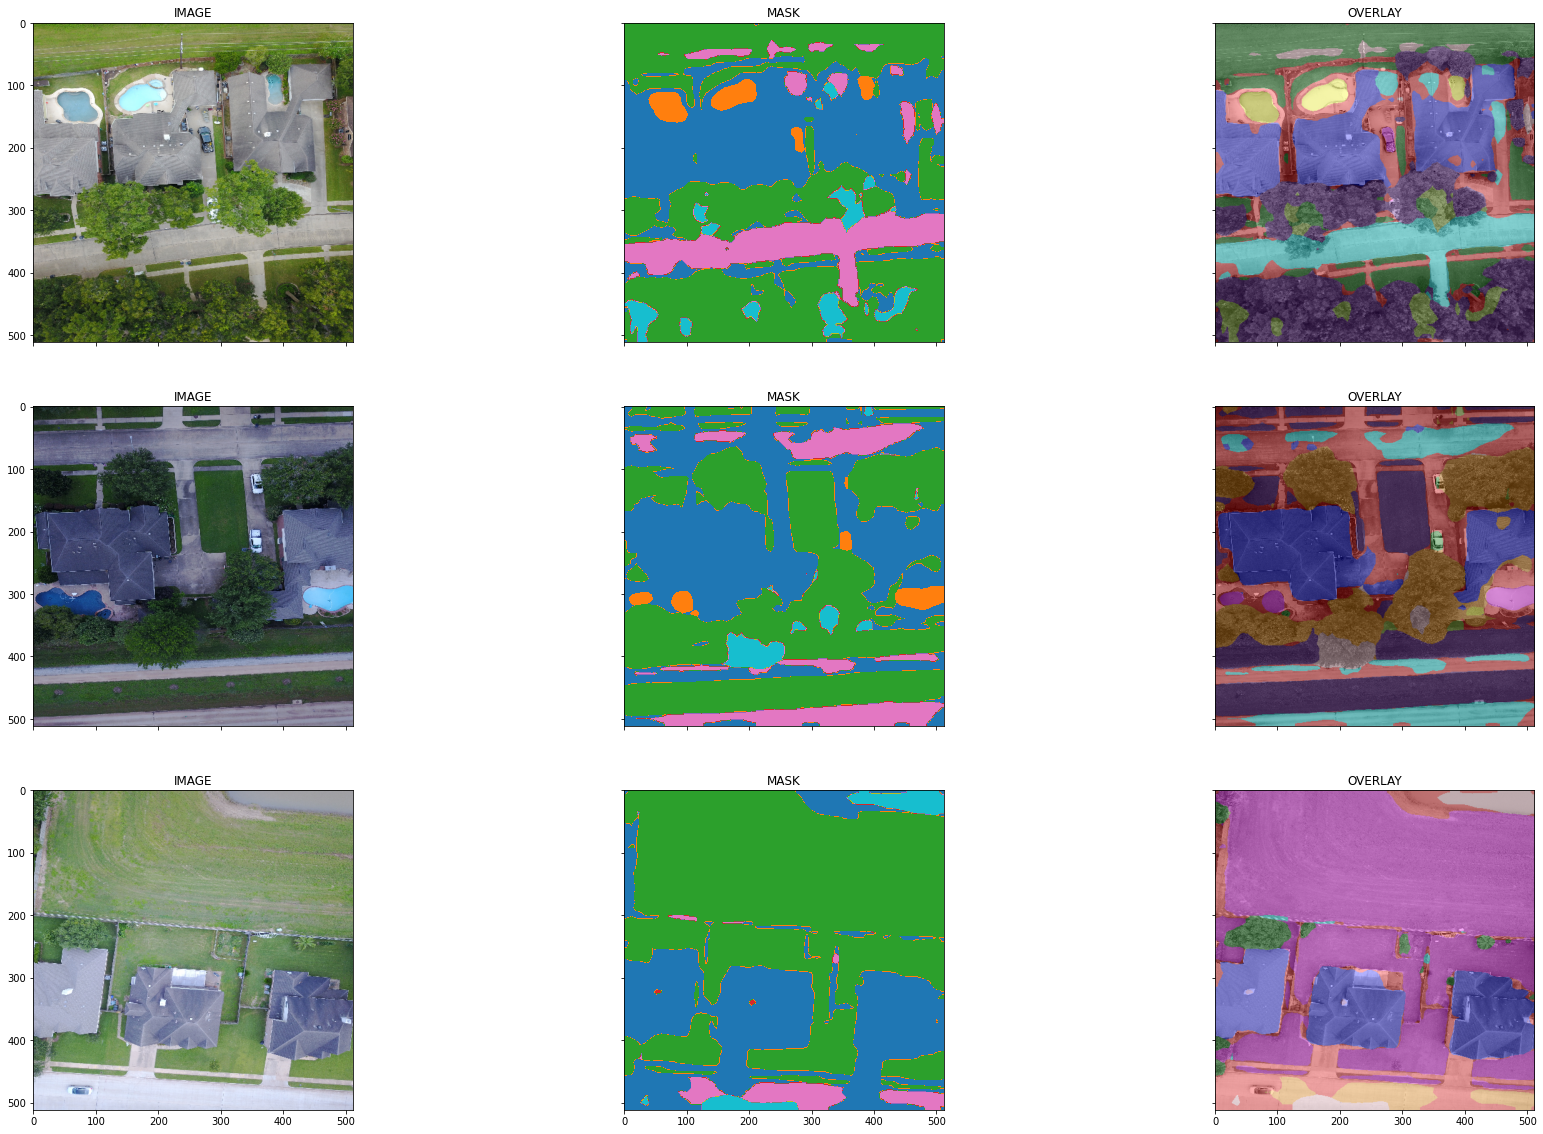

In [30]:
#Example of segmented test images
image1_path = '/content/drive/MyDrive/fdl21-fdl-dsba/test_images/test_images/10812.jpg'
mask1_path = '/content/test/10812.png'
image2_path = '/content/drive/MyDrive/fdl21-fdl-dsba/test_images/test_images/10566.jpg'
mask2_path = '/content/test/10566.png'
image3_path = '/content/drive/MyDrive/fdl21-fdl-dsba/test_images/test_images/6413.jpg'
mask3_path = '/content/test/6413.png'

image1 = cv2.imread(image1_path)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image1 = cv2.resize(image1, (512, 512))
mask1 = cv2.imread(mask1_path, cv2.IMREAD_GRAYSCALE)

image2 = cv2.imread(image2_path)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image2 = cv2.resize(image2, (512, 512))
mask2 = cv2.imread(mask2_path, cv2.IMREAD_GRAYSCALE)

image3 = cv2.imread(image3_path)
image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)
image3 = cv2.resize(image3, (512, 512))
mask3 = cv2.imread(mask3_path, cv2.IMREAD_GRAYSCALE)

fig, axs = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(30,20))

plt.setp(axs[:, 0], title='IMAGE')
plt.setp(axs[:, 1], title='MASK')
plt.setp(axs[:, 2], title='OVERLAY')

axs[0, 0].imshow(image1)
axs[0, 1].imshow(mask1,cmap = 'tab10')
axs[0, 2].imshow(color.label2rgb(mask1,image1))
axs[1, 0].imshow(image2)
axs[1, 1].imshow(mask2,cmap = 'tab10')
axs[1, 2].imshow(color.label2rgb(mask2,image2))
axs[2, 0].imshow(image3)
axs[2, 1].imshow(mask3,cmap = 'tab10')
axs[2, 2].imshow(color.label2rgb(mask3,image3))


In [ ]:
#Zip the folder with test masks for download
!zip -r /content/test_preds.zip /content/test;

  adding: content/test/ (stored 0%)
  adding: content/test/7427.png (deflated 0%)
  adding: content/test/10812.png (deflated 2%)
  adding: content/test/7308.png (deflated 0%)
  adding: content/test/6804.png (deflated 6%)
  adding: content/test/8786.png (deflated 3%)
  adding: content/test/6677.png (deflated 5%)
  adding: content/test/6459.png (deflated 18%)
  adding: content/test/7597.png (deflated 1%)
  adding: content/test/6481.png (deflated 0%)
  adding: content/test/6717.png (deflated 1%)
  adding: content/test/7300.png (deflated 0%)
  adding: content/test/7265.png (deflated 12%)
  adding: content/test/6654.png (deflated 7%)
  adding: content/test/7235.png (deflated 4%)
  adding: content/test/7415.png (deflated 0%)
  adding: content/test/7489.png (deflated 1%)
  adding: content/test/6608.png (deflated 1%)
  adding: content/test/6466.png (deflated 0%)
  adding: content/test/6413.png (deflated 2%)
  adding: content/test/7580.png (deflated 0%)
  adding: content/test/7272.png (deflated